# 프로젝트 : SRGAN 활용하기


## 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기

### 프로젝트 1-1.
1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.  
3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.  
4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.  
5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.  
6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)


1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.

(628, 940, 3)


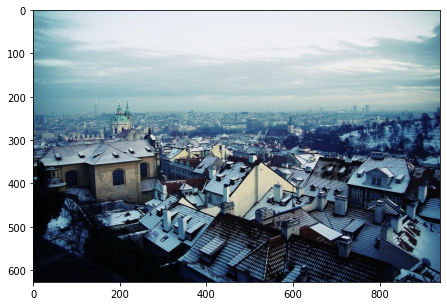

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
img_path = os.getenv('HOME')+'/aiffel/view1.jpeg'  
hr_image = cv2.imread(img_path) 
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)
print (hr_image.shape)

plt.figure(figsize=(10,5))
plt.imshow(hr_image)

2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다. 

(157, 235, 3)


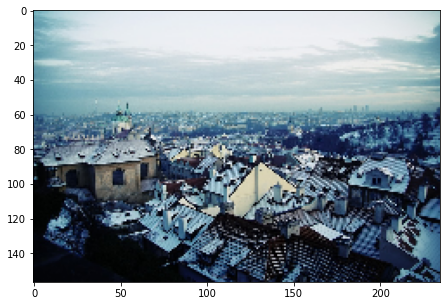

In [2]:

bicubic_hr = cv2.resize(
    hr_image,
    dsize = (hr_image.shape[1]//4, hr_image.shape[0]//4),
    interpolation = cv2.INTER_CUBIC
)

print(bicubic_hr.shape)

plt.figure(figsize=(10,5))
plt.imshow(bicubic_hr)

3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.

In [3]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [4]:
import numpy as np
import tensorflow_datasets as tfds

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(bicubic_hr)
print("✅")

✅


In [5]:
from tensorflow.keras import Input, Model, layers

# 그림의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

# 그림의 뒤쪽 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)
    
# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)

print("✅")

✅


4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.

In [6]:
import cv2

# 이미지를 특정 크기로 줄이고 다시 늘리는 과정을 함수로 정의합니다.
def interpolation_xn(image, n):
    downsample = cv2.resize(
        image,
        dsize=(hr_shape[1]//n, hr_shape[0]//n)
    )
    upsample = cv2.resize(
        downsample,
        dsize=(hr_shape[1], hr_shape[0]),
        interpolation=cv2.INTER_CUBIC
    )
    return upsample



bicubic: (628, 940, 3)


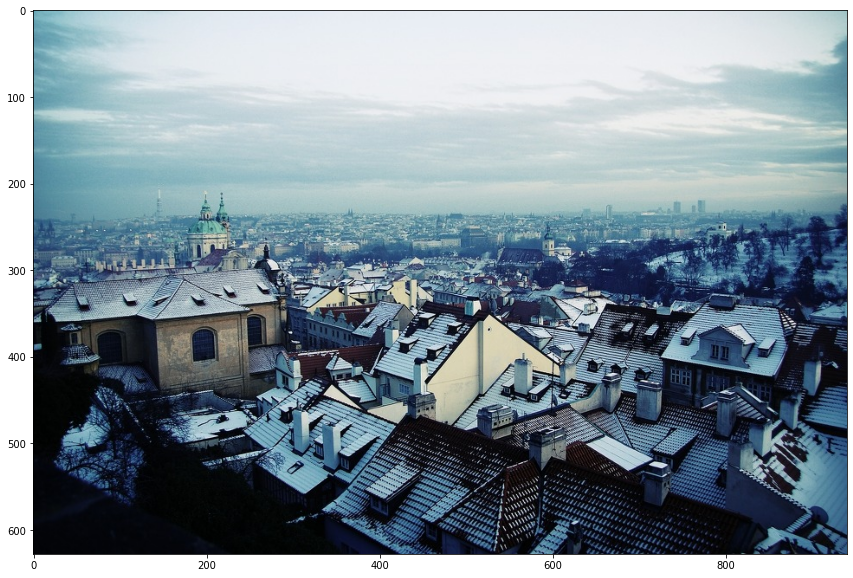

In [7]:
bicubic_hr = cv2.resize(bicubic_hr, dsize=(hr.shape[1], hr.shape[0]), interpolation=cv2.INTER_CUBIC) # 원본사이즈로 복원

bicubic_hr = cv2.resize(
    hr_image,
    dsize = (hr_image.shape[1], hr_image.shape[0]),
    interpolation = cv2.INTER_CUBIC
)

print('bicubic:', bicubic_hr.shape)

plt.figure(figsize=(20,10))
plt.imshow(bicubic_hr)

5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 

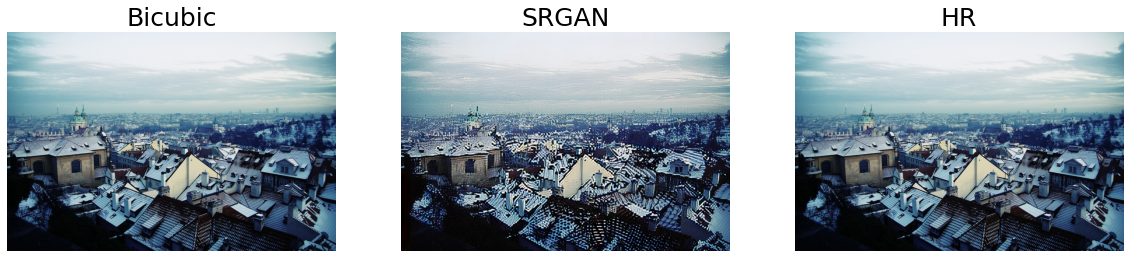

In [8]:
images = [bicubic_hr, srgan_hr, hr_image]
titles = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(20,10))

for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=25)
    plt.axis('off')

In [9]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]



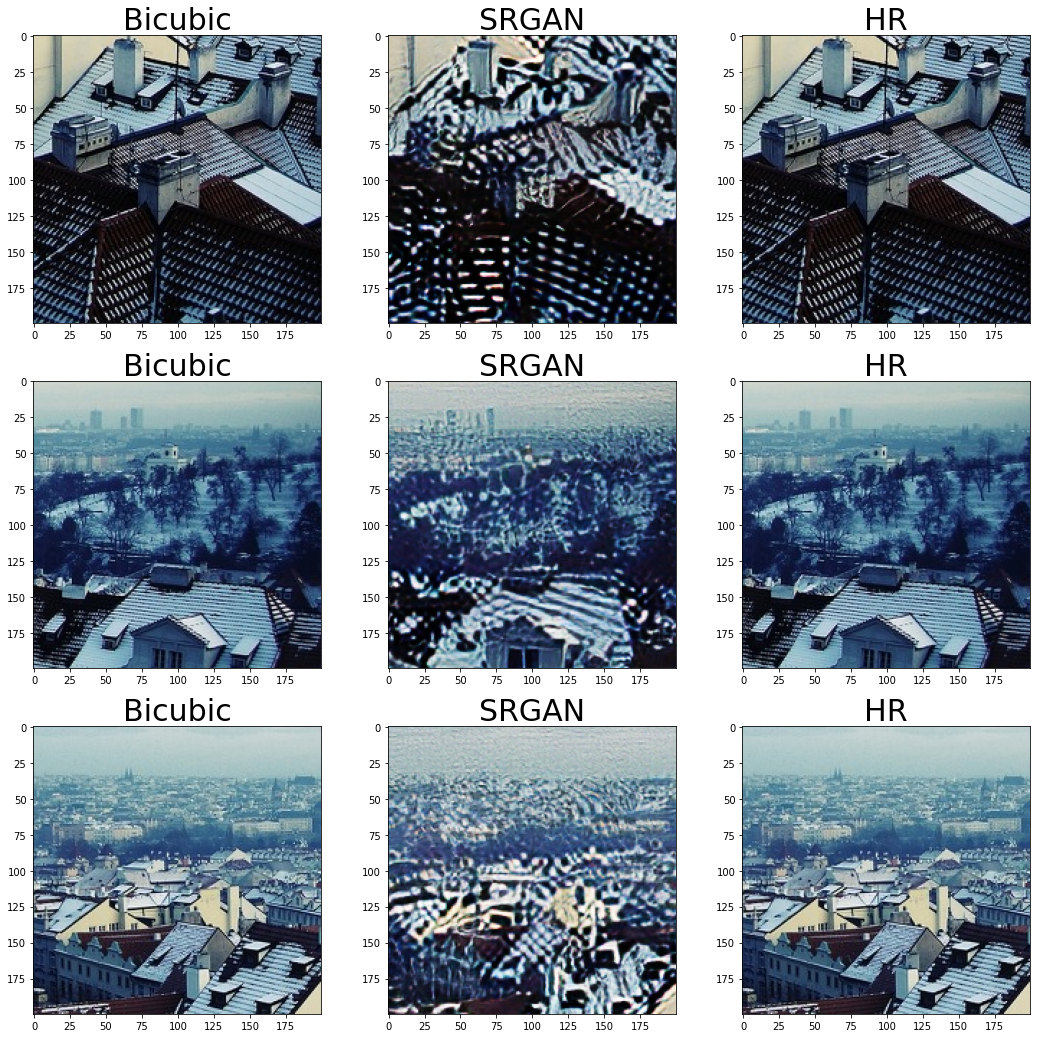

In [10]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(400,500), (200,700), (200,300)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr_image, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

위 결과로 Bicubic과 SRGAN의 특징을 볼 수 있다.

## 프로젝트 1-2

1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.

(360, 480, 3)


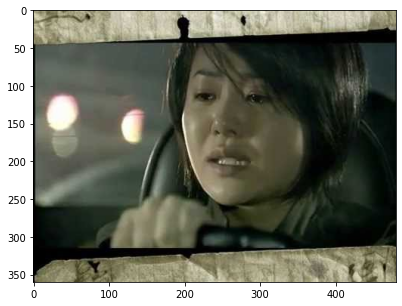

In [11]:
img_path = os.getenv('HOME')+'/aiffel/lowimage.jpeg'  
low_image = cv2.imread(img_path) 
low_image = cv2.cvtColor(low_image, cv2.COLOR_BGR2RGB)
print (low_image.shape)

plt.figure(figsize=(10,5))
plt.imshow(low_image)

2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.

In [12]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

import numpy as np
import tensorflow_datasets as tfds

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(low_image)
print("✅")

✅


3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.

In [13]:
bicubic_hr = cv2.resize(
    low_image, 
    dsize=(low_image.shape[1]*4, low_image.shape[0]*4), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.

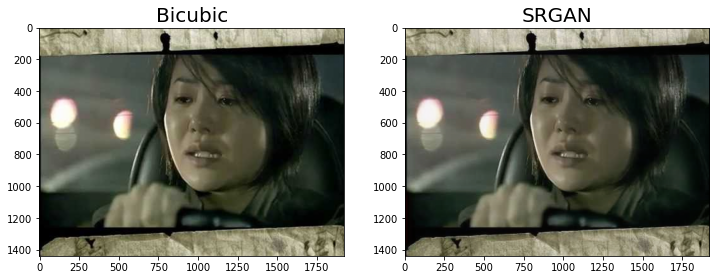

In [14]:
images = [bicubic_hr, srgan_hr]
titles = ["Bicubic", "SRGAN"]

plt.figure(figsize=(12,5))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

음..

5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다

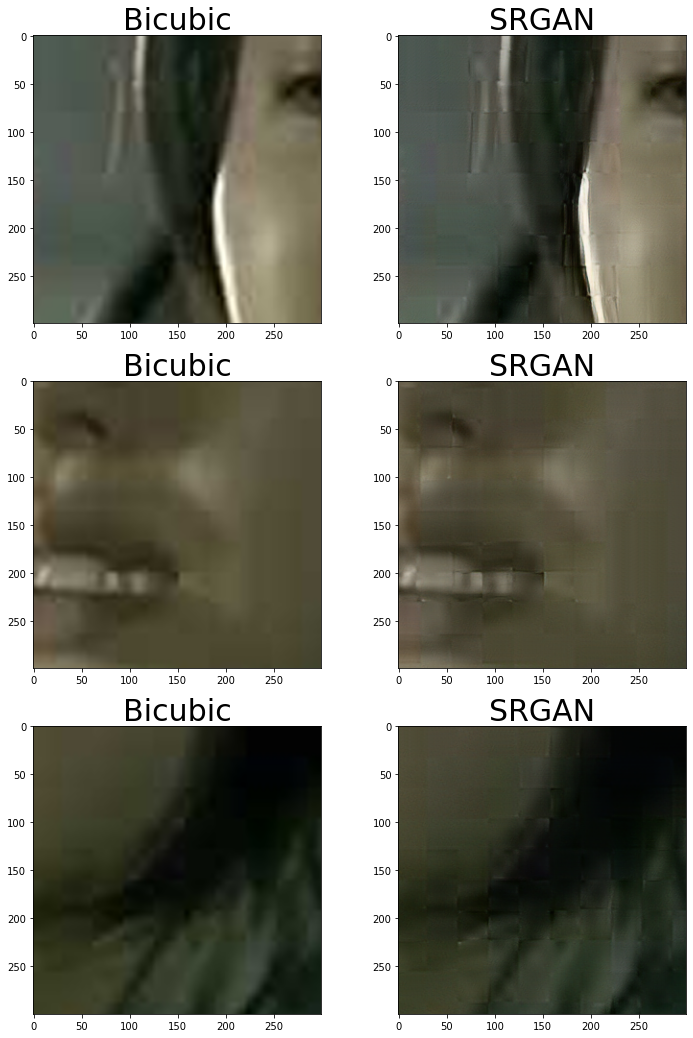

In [15]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
left_tops = [(400,600), (600,1000), (800,1250)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 300, 300)
    img2 = crop(srgan_hr , left_top, 300, 300)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(12,18))
for i in range(6):
    plt.subplot(3,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

Bicubic의 경우 이미지의 경계선이 부드러운 반면, SRGAN의 이미지는 픽셀영역이 살아있어 보인다.

# 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기

## 1. gif 파일 불러오기

In [16]:
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif_path = os.getenv('HOME') + '/aiffel/super_resolution'
gif = cv2.VideoCapture(os.path.join(gif_path, 'fire_lr.gif'))


isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 14
frame 크기 : (282, 300, 3)


## 2. 프레임별 Super Resolution 진행하기


In [17]:
#픽셀 수 4배로 늘린다.

frames_sr_bicubic = []
for i in frames: 
    bi_i = cv2.resize(i, dsize=(i.shape[1]*4, i.shape[0]*4), interpolation=cv2.INTER_CUBIC) 
    frames_sr_bicubic.append(bi_i)

In [18]:
frames_sr_srgan = []
for i in frames:
    srgan_i = apply_srgan(i)
    frames_sr_srgan.append(srgan_i)

## 3. 프레임을 합쳐 gif 만들기

In [19]:
import imageio

imageio.mimsave(gif_path + "/fire_hr_bicubic.gif", frames_sr_bicubic)
imageio.mimsave(gif_path + "/fire_hr_srgan.gif", frames_sr_srgan)

## 4. Jupyter notebook에 gif 표시하기

In [22]:
from IPython.display import Image as show_gif

# show_gif(gif_path+'/fire_hr.gif', width=400)
# show_gif(gif_path+'/fire_hr_bicubic.gif', width=400)
# show_gif(gif_path+ '/fire_hr_srgan.gif', width=400)

원본  
https://8888-wej81cd12pfsrqm94qmgvyb3l.e.aiffel-4.ainetwork.ai/view/aiffel/super_resolution/fire_lr.gif

Bicubic  

https://8888-wej81cd12pfsrqm94qmgvyb3l.e.aiffel-4.ainetwork.ai/view/aiffel/super_resolution/fire_hr_srgan.gif

SRGAN  
https://8888-wej81cd12pfsrqm94qmgvyb3l.e.aiffel-4.ainetwork.ai/view/aiffel/super_resolution/fire_hr_bicubic.gif

## 루브릭
평가문항	상세기준
1. SRGAN을 이용해 고해상도의 이미지를 생성하였다.  
SRGAN을 통해 생성된 이미지를 제출하였다.


2. 다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN생성본, interpolation생성본을 비교분석하였다.  
이미지의 특성과 super resolution 방법을 관련지어 생성 결과를 체계적으로 분석하였다.


3. 저해상도 gif 동영상을 고해상도 동영상으로 성공적으로 변환하였다.  
저해상도 원본 gif와 생성된 고해상도 gif의 해상도 차이가 시각적으로 확인 가능하다.

### 정리
SRGAN을 통해 해상도를 높이는 방법을 시도했다. Bicubic과 비교해보면서 어떻게 달라지는지 확인할 수 있었다. 
Bicubic의 경우 이미지의 경계선이 부드러운 반면, SRGAN의 이미지는 픽셀영역이 살아있어 보여서 그런지 수묵화같은 느낌의  
이미지를 만들어 냈는데, 이것은 super resolution과정에서 나온 기존 픽셀 기반으로 새로운 픽셀을 생성해서 그런 것 같다. 
전반적인 학습 과정을 통해 interpolation이 어떻게 새로운 픽셀을 만들어 내는지 알 수 있었고, 이러한 기법이 의료, cctv  , 영상자료에 어떤 식으로 쓰여지는 지 알 수 있었다. 때마침 다른 의료AI관련 세미나를 들으면서 향후 어떻게 활용될 지에 대한  상상을 해볼 수 있던 시간이 됐다.